# Time series forecasting with DeepAR - Wikimedia pageview data

- This notebook we train a deepAR model using 2Years/ over all available of wiki-projects pageview data within requested time range, and test the model with both wiki and synthetic data.  
- Model pipeline: Request to Wiki REST api >> save_jason() to S3 bucket >> train model >> deploy trained model on Sagemaker, create endpoint >> request inference >> get prediction >> evaluation with test metric 

In [1]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt
#from preprocessor import save_json

In [2]:
!conda install -y s3fs

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.6.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - s3fs


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2018.12.5  |                0         123 KB

The following packages will be UPDATED:

    ca-certificates: 2018.8.24-ha4d7672_0 conda-forge --> 2018.12.5-0      
    certifi:         2018.8.24-py36_1     conda-forge --> 2018.11.29-py36_0
    openssl:         1.0.2p-h470a237_0    conda-forge --> 1.0.2p-h14c3975_0
    s3fs:            0.1.5-py36_0                     --> 0.2.0-py36_0     


ca-certificates-2018 | 123 KB    | ##################################### | 100% 

FileExistsError(17, 'File exis

In [3]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [4]:
bucket = 'sagemaker-deepar20190120'
prefix = 'sagemaker/wiki-test-deepar'

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [5]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

### Predict setting

We predict the next 48 points of time series.
The time series that we use have hourly granularity.

In [6]:
freq = 'H'
prediction_length = 48

`context_length`: how many previous points to look at. A typical value to start with is around the same size as the `prediction_length`.

In [7]:
context_length = 118

Useful functions convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3. (didn't call during this example)

In [8]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

### Get wikimedia pageview data from its REST API
We request the http requests sent by users to wiki projects. The output will be a json file with required format, each line contains hourly pageview numbers from `start` to `end`. Output files are saved in a S3 bucket.
- (A side note: wiki api allows 200 requests/s maximum, don't get blacklisted.)
- (Anote side note: the response will be json objects, each has a time stamp and corresponding time series values such as pageview, the maximum number of returned objects is 5000 that's why I use time delta = 200 days = 4800 objects for each request)

In [9]:
import datetime
import requests
import json
import time

all_data = []
project_list = []
delta = datetime.timedelta(days=199)
hour = datetime.timedelta(hours=1)
zero = datetime.timedelta(hours=0)


def save_json(start, end, out_path, input_path):
    s3filesystem = s3fs.S3FileSystem()
    start_date = datetime.datetime.strptime(start, '%Y%m%d')
    end_date = datetime.datetime.strptime(end, '%Y%m%d')
    if (end_date - start_date).days < 0:
        raise Exception('start date should NOT after end date')

    expected_size = ((end_date - start_date).days + 1) * 24

    # provide wiki-project list here!
    with open(input_path) as f:
        projects = f.read().splitlines()

    for item in projects:
        data = get_single_views(item, start_date, end_date)
        if len(data['target']) == expected_size:
            all_data.append(data)
            project_list.append(item)

    # convert all items to JSON and write to a file
    print('saving data')
    print(project_list)
    with open(input_path[:-4] + '-' + str(start) + '-' + str(end) + '-get.txt', 'w') as f:
        for item in project_list:
            f.write("%s\n" % item)
    with s3filesystem.open(out_path, 'w') as outfile:
        outfile.write('\n'.join(json.dumps(i) for i in all_data) + '\n')
    all_data.clear()
    project_list.clear()


def get_single_views(item, start_date, end_date):
    base_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/' \
               + item \
               + '/all-access/user/hourly/'
    # dict is used to save JSON of each domain
    data = dict()
    data['start'] = start_date.strftime('%Y-%m-%d') + ' 00:00:00'
    data['target'] = []

    while start_date <= end_date:
        if start_date + delta <= end_date:
            final_url = base_url + start_date.strftime('%Y%m%d') + '00/' \
                        + (start_date + delta).strftime('%Y%m%d') + '23'
            end_check = start_date + delta + 23 * hour
        else:
            final_url = base_url + start_date.strftime('%Y%m%d') + '00/' \
                        + end_date.strftime('%Y%m%d') + '23'
            end_check = end_date + 23 * hour
        # make a API request here!!!
        response = requests.get(final_url)
        time.sleep(0.05)
        try:
            response.raise_for_status()
        except requests.exceptions.HTTPError as e:
            print("<-----Error---->: " + final_url + str(e))
            break
        print('<-----OK----->' + final_url)  # debug
        output = response.json()
        print('processed data points: ' + str(len(output['items'])))  # debug
        temp = start_date - hour
        for i in output['items']:
            curr = datetime.datetime.strptime(i['timestamp'], '%Y%m%d%H')
            while curr - temp > hour:
                data['target'].append(None)
                temp += hour
            data['target'].append(i['views'])
            temp = curr

        while (end_check - temp) > zero:
            data['target'].append(None)
            temp += hour

        start_date += datetime.timedelta(days=200)

    return data

In [10]:
# train_start = '20160101'
# train_end = '20171231'
# save_json(train_start,train_end,s3_data_path + "/train_0toNaN/train.json", 'wp_full.txt')
# test_start = '20180101'
# test_end = '20181231'
# save_json(test_start,test_end,s3_data_path + "/test_0toNaN/test.json", 'wp_full.txt')

### Train a model

In [11]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    base_job_name='DEMO-deepar',
    output_path="s3://" + s3_output_path
)

In [12]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "35",
    "num_layers": "2",
    "likelihood": "student-t",
    "epochs": "39",
    "mini_batch_size": "85",
    "learning_rate": "0.0030902721170490166",
    "dropout_rate": "0.052384954005170334",
    "early_stopping_patience": "10"
}

In [13]:
estimator.set_hyperparameters(**hyperparameters)

In [14]:
data_channels = {
    "train": "s3://{}/train_0toNaN/".format(s3_data_path),
    "test": "s3://{}/test_0toNaN/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: DEMO-deepar-2019-02-05-03-33-24-353


2019-02-05 03:33:24 Starting - Starting the training job...
2019-02-05 03:33:27 Starting - Launching requested ML instances...
2019-02-05 03:34:24 Starting - Preparing the instances for training......
2019-02-05 03:35:18 Downloading - Downloading input data
2019-02-05 03:35:18 Training - Downloading the training image......
2019-02-05 03:36:09 Training - Training image download completed. Training in progress.
Arguments: train
[02/05/2019 03:36:11 INFO 140613173692224] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'li

### Create endpoint and predictor

In [15]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: DEMO-deepar-2019-02-05-03-33-24-353
INFO:sagemaker:Creating endpoint-config with name DEMO-deepar-2019-02-05-03-33-24-353
INFO:sagemaker:Creating endpoint with name DEMO-deepar-2019-02-05-03-33-24-353


---------------------------------------------------------------------------!

In [16]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [17]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

## Make predictions, plot and evaluate the results

### Make prediction for `wiki` data

In [18]:
# data_location = "s3://{}/test/test.json".format(s3_data_path)
data_location = "s3://{}/test_0toNaN/test.json".format(s3_data_path)
df_ts = pd.read_json(data_location, lines = True)
df_ts.head()

,start,target
0,2018-01-01 00:00:00,"[93, 6, 12, 17, 113, 17, 70, 5, 100, 92, 51, 1..."
1,2018-01-01 00:00:00,"[None, 1, None, None, None, 2, None, None, 1, ..."
2,2018-01-01 00:00:00,"[None, 1, 1, 1, 1, 2, 1, 7, 3, None, 7, 5, 1, ..."
3,2018-01-01 00:00:00,"[69, 74, 102, 102, 104, 65, 65, 79, 55, 108, 2..."
4,2018-01-01 00:00:00,"[None, None, 2, 1, None, 2, 1, 1, None, None, ..."


In [19]:
num_pt = len(df_ts.iloc[1,1])
num_ts = len(df_ts)

time_series_wiki = [] 
for k in range(num_ts):
    t0 = df_ts.iloc[k,0]
    data = df_ts.iloc[k,1]
    index = pd.DatetimeIndex(start=t0, freq=freq, periods=num_pt)
    ts = pd.Series(data=data, index=index)
    ts_0val = ts.replace(to_replace=np.nan, value=0, inplace = False)
    time_series_wiki.append(ts_0val)

In [20]:
time_series_wiki_predict = []
for ts in time_series_wiki:
    time_series_wiki_predict.append(ts[:-prediction_length])

In [21]:
# result of prediction will be stored in list_of_wiki_pred
list_of_wiki_pred = []
for i in range(0,len(time_series_wiki_predict)):
    list_of_wiki_pred.append(predictor.predict(time_series_wiki_predict[i:i+1]))
    # The following line is added to avoid time out error.
    time.sleep(0.01) 

### A quick overview of the prediction

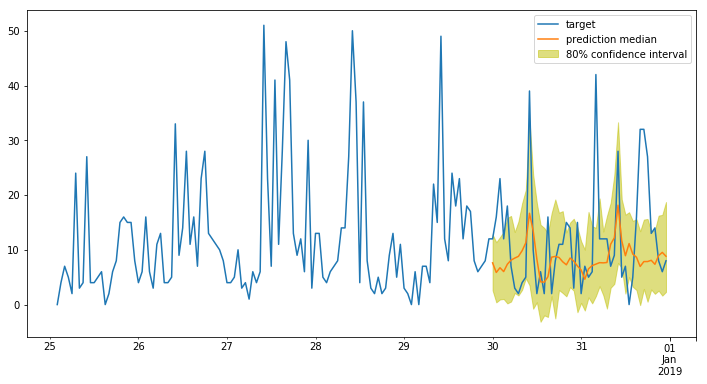

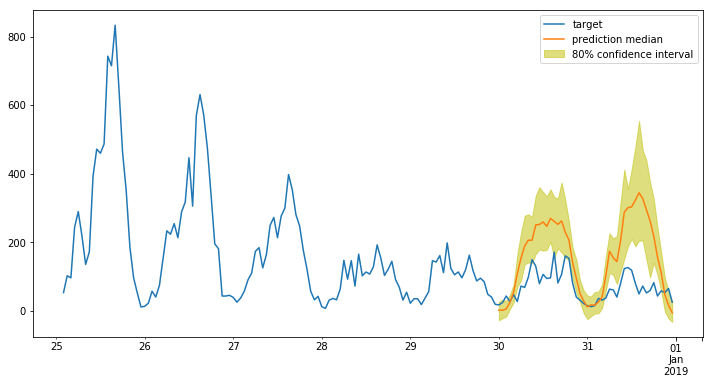

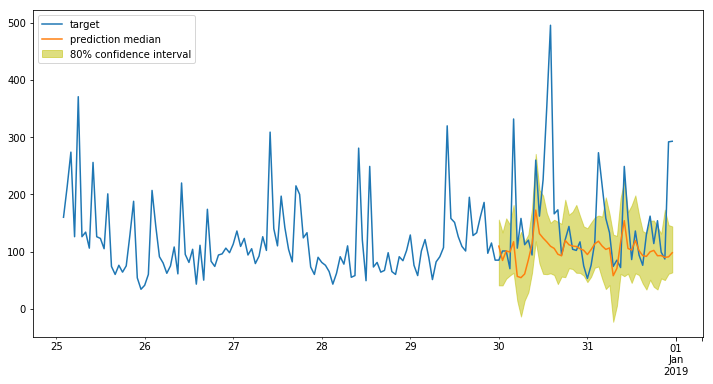

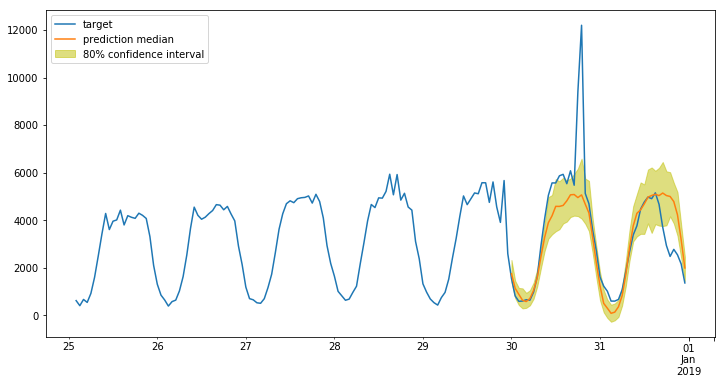

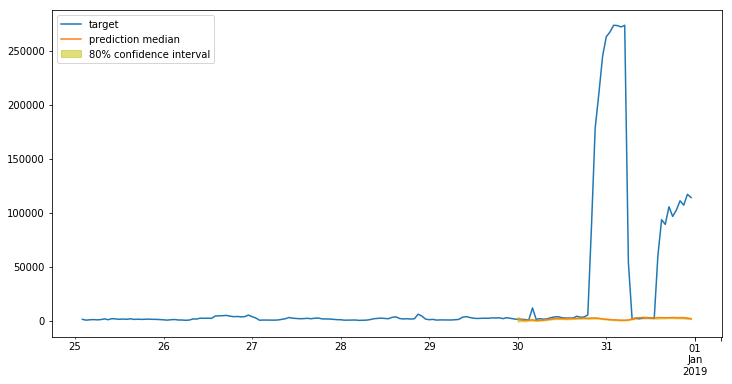

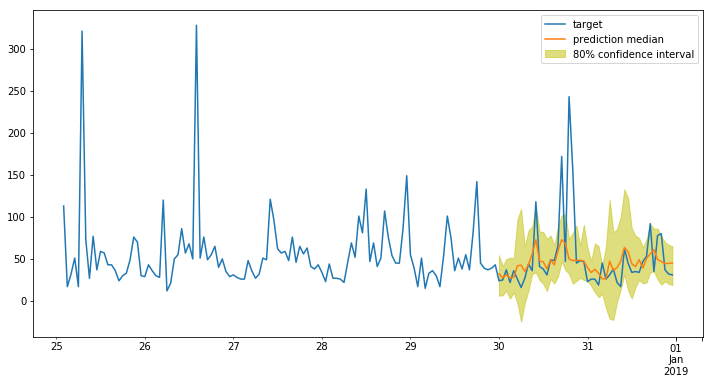

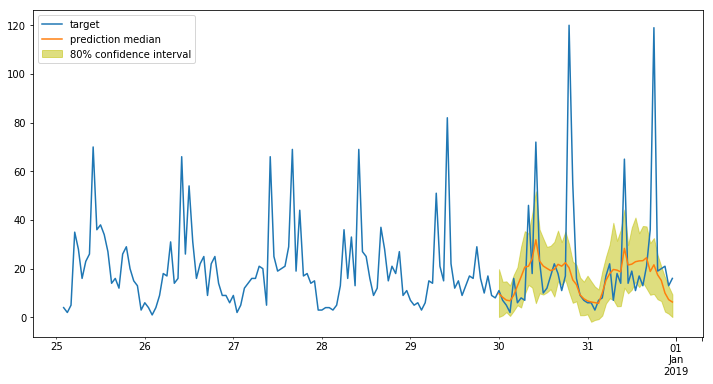

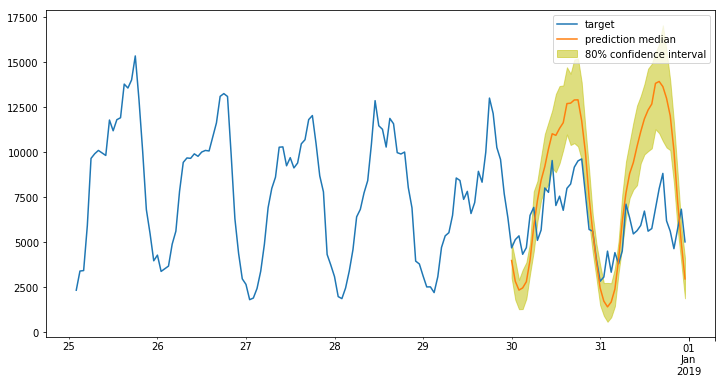

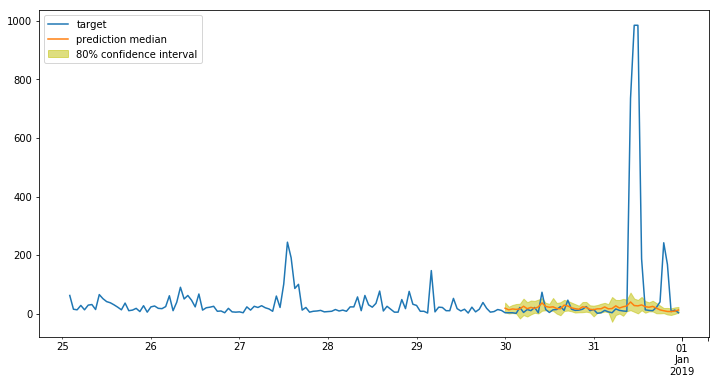

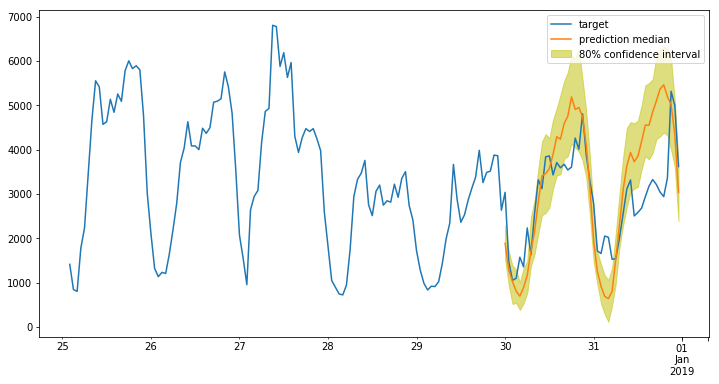

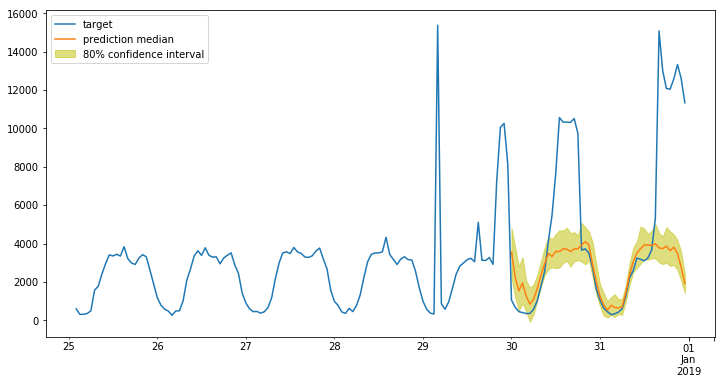

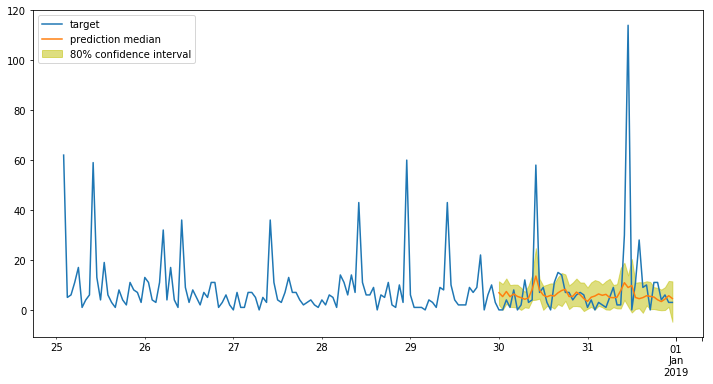

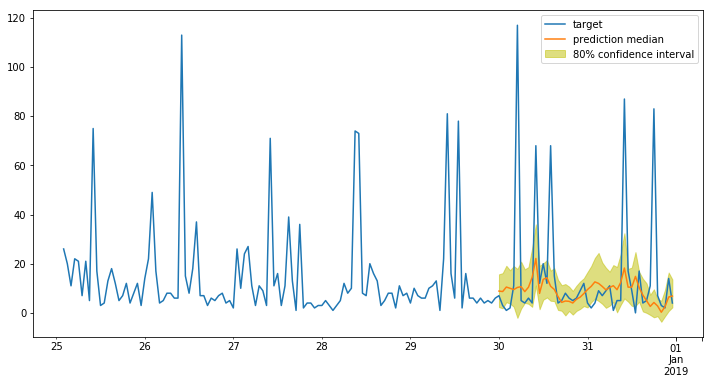

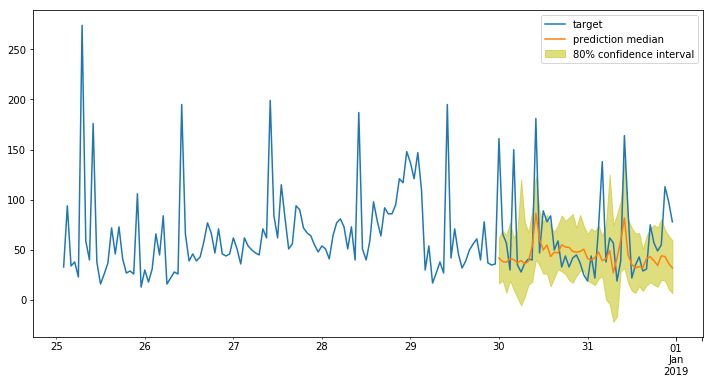

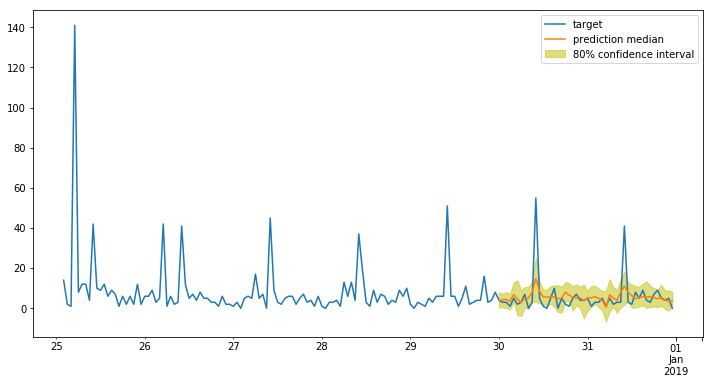

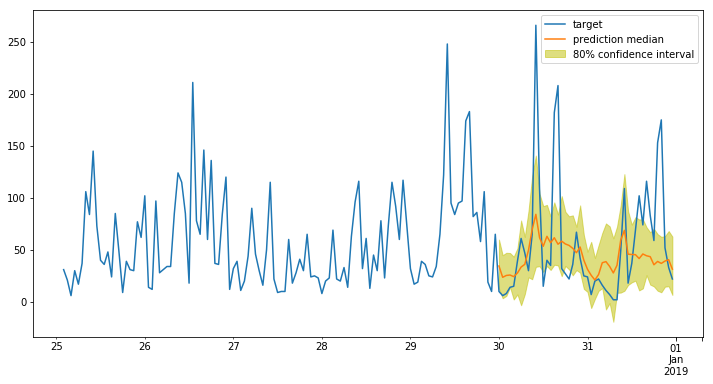

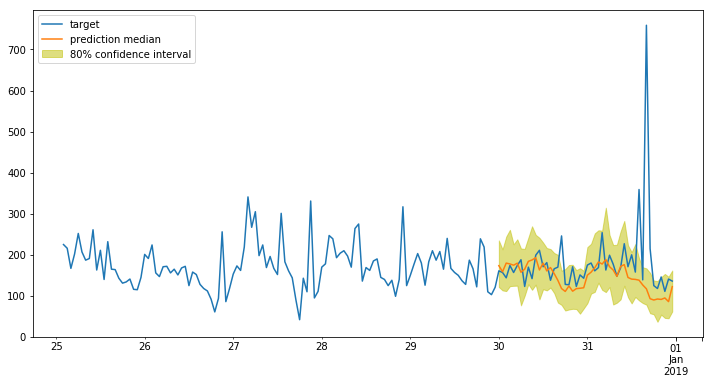

In [22]:
# sample several predicted time series use range(0, len(list_of_wiki_pred), 50)
for k in range(0, len(list_of_wiki_pred), 50):
    plt.figure(figsize=(12,6))
    time_series_wiki[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.legend(loc = 'best')
    plt.show()

### Metrics to evaluate the prediction
- Mean absolute percentage error
- Mean absolute error with log1p
- Symmetric mean absolute percentage error
- Symmetric mean absolute percentage error differentiable
- others?

In [23]:
# Approximated differentiable SMAPE
def differentiable_smape(true, predicted):
    epsilon = 0.1
    true_o = true
    pred_o = predicted
    summ = np.maximum(np.abs(true_o) + np.abs(pred_o) + epsilon, 0.5 + epsilon)
    smape = np.abs(pred_o - true_o) / summ
    return smape

# SMAPE, rounded up to the closest integer
def rounded_smape(true, predicted):
    true_o = np.int(np.round(true))
    pred_o = np.round(predicted).astype(np.int32)
    summ = np.abs(true_o) + np.abs(pred_o)
    smape = np.where(summ==0, 0, np.abs(pred_o - true_o) / summ)
    return smape

# SMAPE stardard definition
def smape(true, predicted):
    true_o = true
    pred_o = predicted
    summ = np.abs(true_o) + np.abs(pred_o)
    smape = np.where(summ==0, 0, np.abs(pred_o - true_o) / summ)
    return smape

# MAE standard definition
def mape(true, predicted):
    true_o = true
    pred_o = predicted
    denom = np.abs(true_o)
    mape = np.where(denom==0, 0, np.abs(pred_o - true_o) / denom)
    return mape


# MAE on log1p
def mape1p(true, predicted):
    epsilon = 0.1
    true_o = np.log1p(true + epsilon)
    pred_o = np.log1p(predicted + epsilon)
    error = np.where(np.abs(true_o)==0, 0, np.abs(pred_o - true_o) / np.abs(true_o))
#     error = np.abs(true_o - pred_o)/np.abs(true_o)
    return error

In [24]:
# input pd.series in which index = time stamps, value = time series values
# actual_series and pred_series should have exactly matched timestamps

def plot_metrics(actual_series, pred_series):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    metric_smape = differentiable_smape(actual_series.values, pred_series.values)
    metric_mape = mape(actual_series.values, pred_series.values)
    metric_maelog1p = mape1p(actual_series.values, pred_series.values)
    metric_smape_orig = smape(actual_series.values, pred_series.values)
    plt.figure(figsize=(12,6))
    plt.plot(pred_series.index, metric_smape_orig, label = 'smape standard = {}'.format(metric_smape_orig.mean()))  
    plt.plot(pred_series.index, metric_smape, label = 'smape differentialble = {}'.format(metric_smape.mean()))
    plt.plot(pred_series.index, metric_mape, label = 'mape standard = {}'.format(metric_mape.mean()))
    # plt.plot(pred_series.index, metric_maelog1p, label = 'mape with log(1 + epsilon +val) = {}'.format(metric_maelog1p.mean()))
    plt.xlabel('Time stamp of prediction')
    plt.ylabel('Prediction metric')
    plt.legend(loc = 'best')
    plt.show()

### Plot the metrics for wiki data prediction

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in true_divide


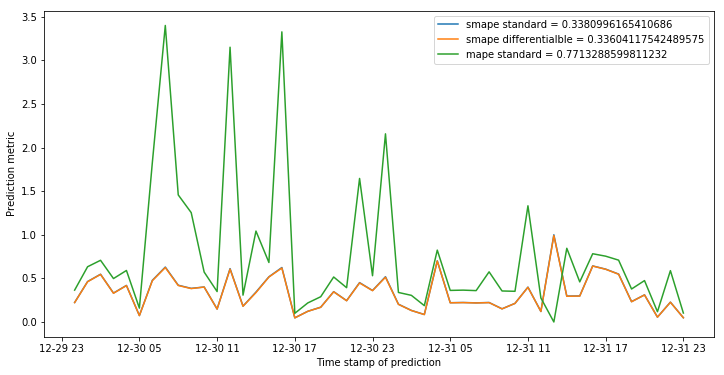

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in log1p


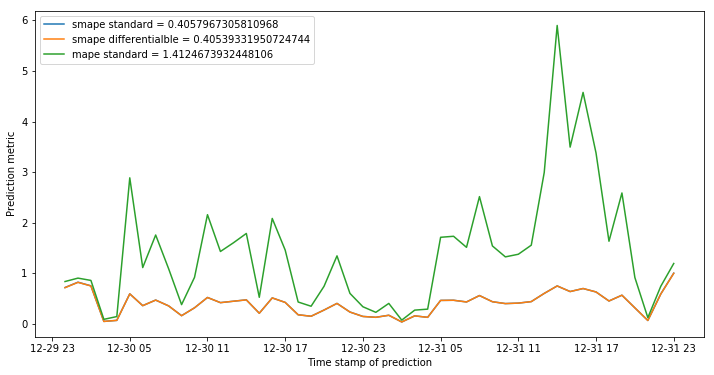

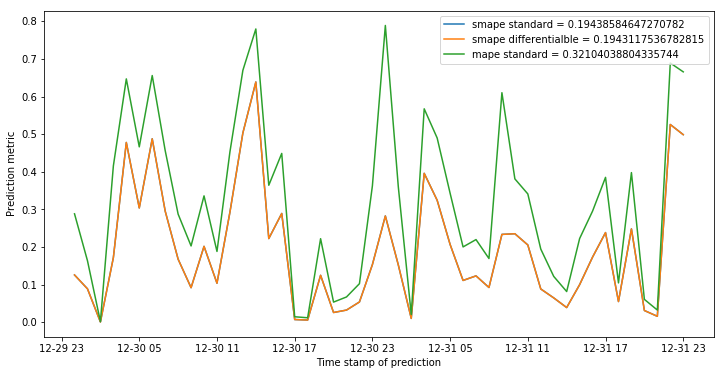

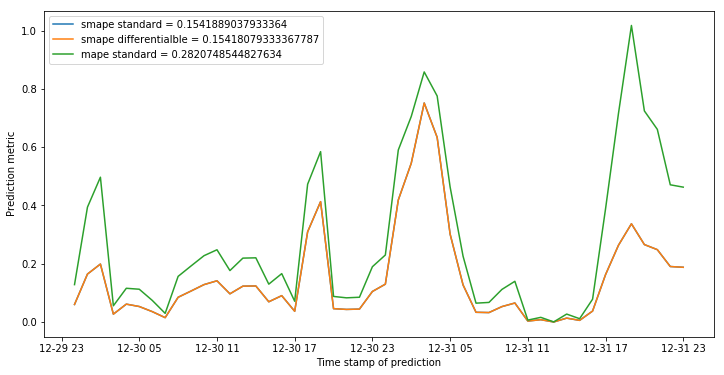

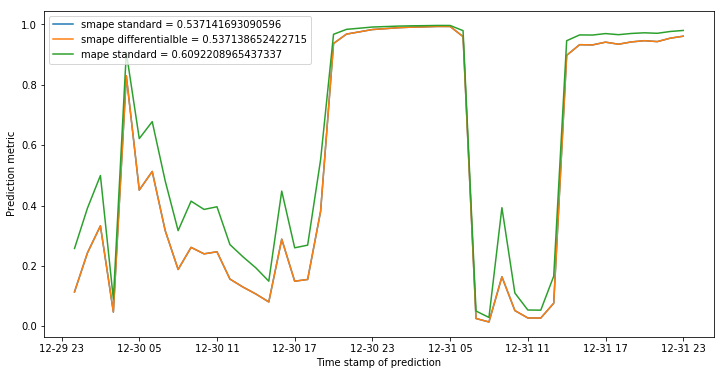

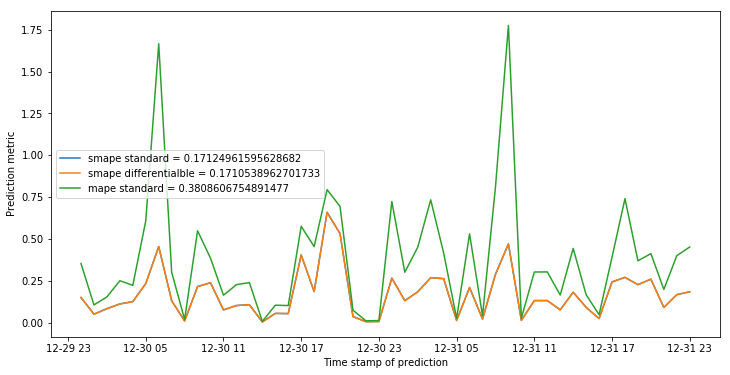

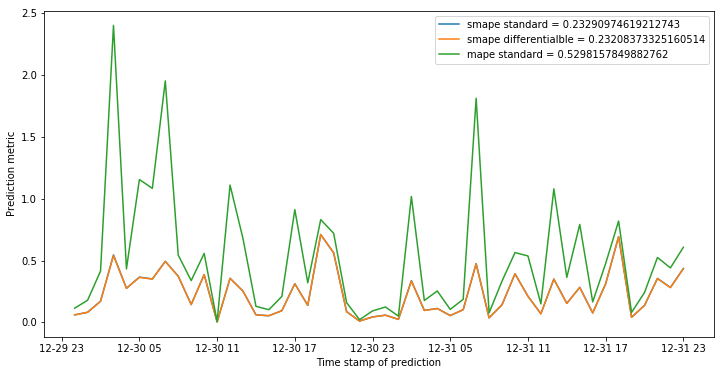

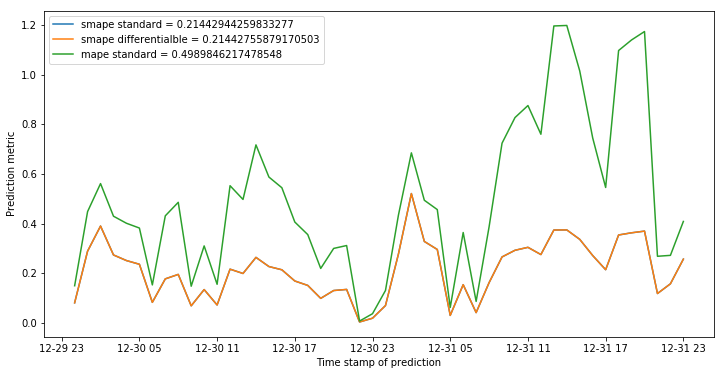

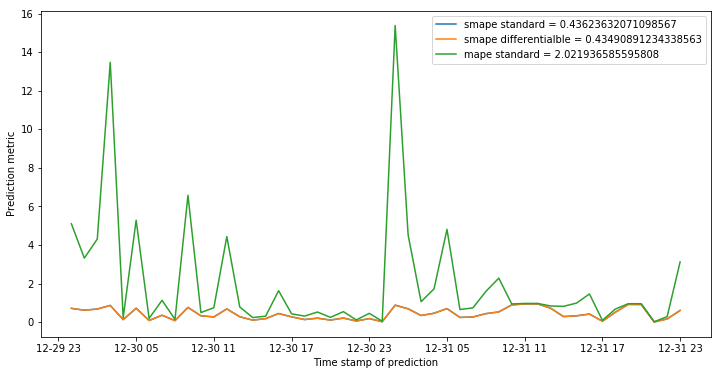

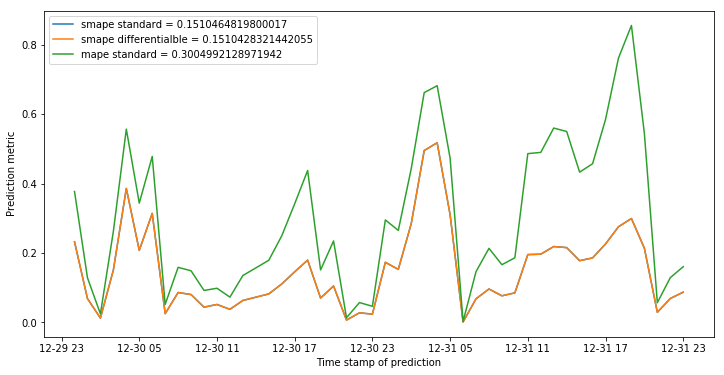

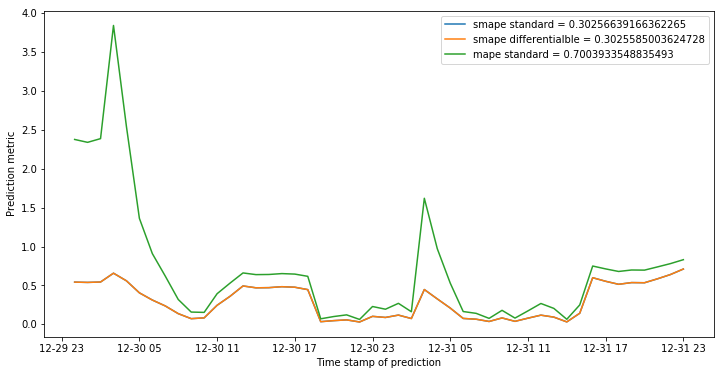

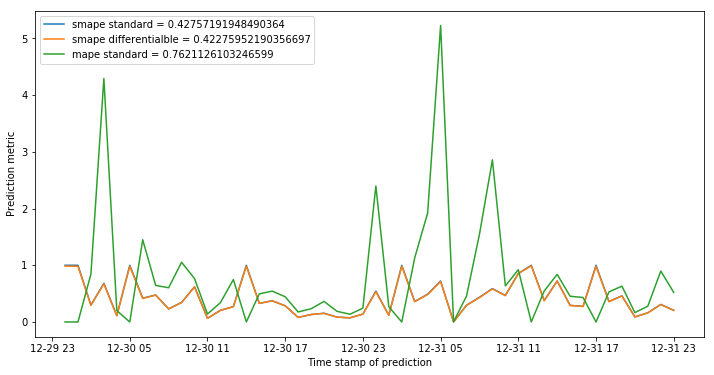

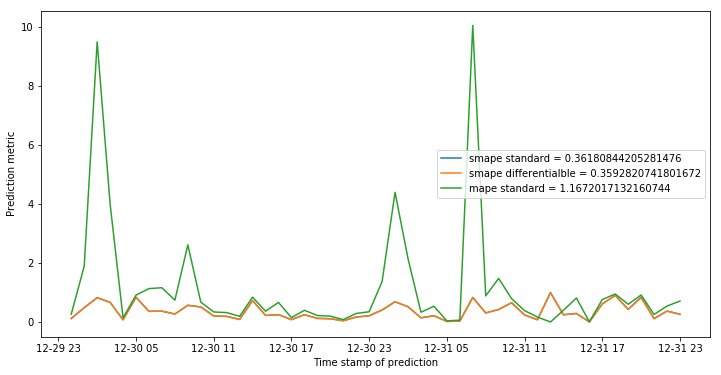

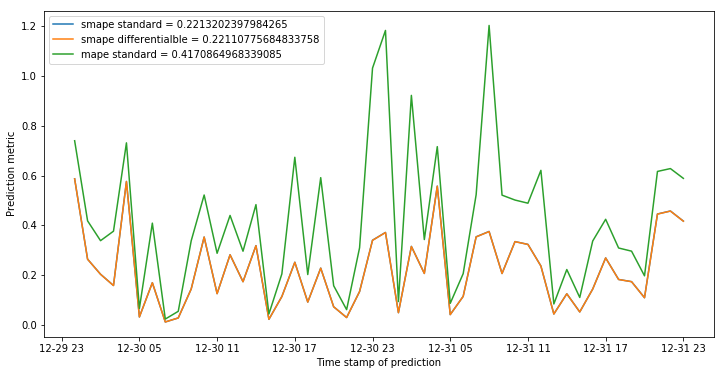

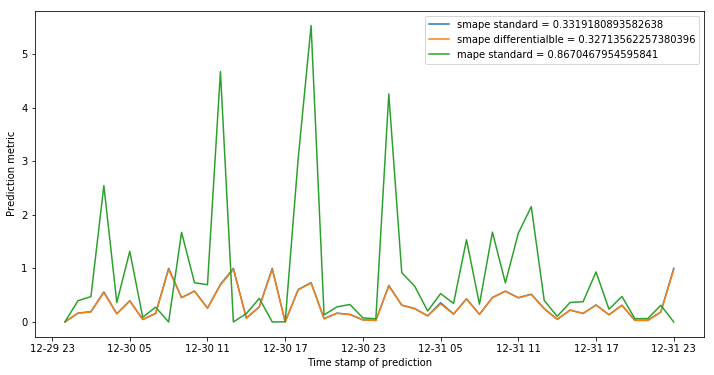

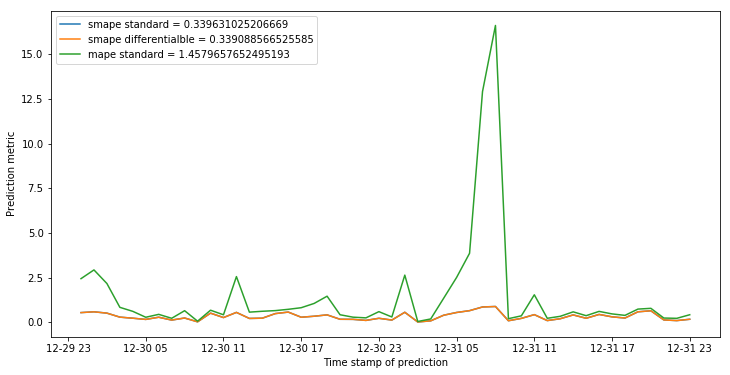

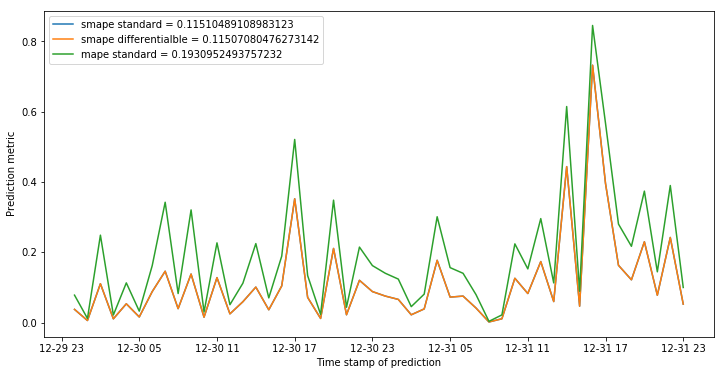

In [25]:
for k in range(0, len(list_of_wiki_pred), 50):
    plot_metrics(time_series_wiki[k][-prediction_length:], list_of_wiki_pred[k][0]['0.5'])


In [26]:
import heapq
# This function characterize time series with FFT.
def characterize_ts(ts,window):
    y = ts.values # signal
    Fs = 1 # sampling rate, in our case let's use 1 Hour^-1
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    # We only keep the positive frequency up to the Nyquist = 1/(2*dT), dT = sampling interval.
    cycle = frq[range(1,int(n/2))] * window # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(1, int(n/2))] # again, spectrum corrresponding to the positive half
    yabs = np.abs(Y)
    
    # Locate the largest 15 peaks, use them to characterise the time series.
    indx = heapq.nlargest(15, range(len(yabs)), yabs.__getitem__)
    amp = heapq.nlargest(15,yabs)

    mean = yabs.mean()
    std = yabs.std()
    cyc_hday = 2.0
    cyc_day = cyc_hday / 2.0
    cyc_week = cyc_day / 7.0
    cyc_month = cyc_day / 30.0

    comp = lambda a,b : np.abs(a/b - 1) < 0.05
    ts_type = ['trend', 'hDay', 'Day', 'Week', 'Month', 'DayImpulse', 'spike']
    report_list = [0] * 8
    for counter, value in enumerate(indx):
        # Here we define a peak in frequency domain.
        if amp[counter] > (mean + 3*std):
            amp_norm = (amp[counter] - mean)/std
            if cycle[value] < 0.01:
                # trend (increasing, decreasing, gaussian pulse)
                report_list[0] = max(amp_norm,report_list[0])
            elif comp(cycle[value], cyc_hday):
                report_list[1] = max(amp_norm,report_list[1])
            elif comp(cycle[value], cyc_day):
                report_list[2] = max(amp_norm,report_list[2])
            elif comp(cycle[value], cyc_week):
                report_list[3] = max(amp_norm,report_list[3])
            elif comp(cycle[value], cyc_month):
                report_list[4] = max(amp_norm,report_list[4])

    if sum(report_list[:5]) > 0:
        index = report_list[:5].index(max(report_list[:5])) 
        report_list[5] = ts_type[index]
    else: 
        report_list[5] = ts_type[-1]
        
    # Add a subcategory: a special day seasonality that has a periodic impulse shape.    
    if (report_list[5] == 'hDay' or report_list[5] == 'Day'):
        harmonic = set(range(12))
        all_peak = set()
        for counter, value in enumerate(indx):
            if amp[counter] > (mean + 3*std):
                all_peak.add(int(round(cycle[value])))
        if len(harmonic.intersection(all_peak)) > 10 :
            report_list[5] = ts_type[-2]

    report_list[-2] = y.mean()
    report_list[-1] = y.std()
    return report_list

In [27]:
character_list = []
day = 24
for item in time_series_wiki:
    character_list.append(characterize_ts(item,day))

In [28]:
error_list = []
for i in range(len(list_of_wiki_pred)):
    metric_smape = differentiable_smape(time_series_wiki[i][-prediction_length:].values, 
                                        list_of_wiki_pred[i][0]['0.5'].values)
    error_list.append(metric_smape.mean())
# Print the mean error across all test time series.    
print(sum(error_list)/len(error_list))

0.2522671367832279


### By classifying the time series into different buckets, we can see how the model performs on different types of time series.

- The major types of time series in the wiki dataset are: Day seasonality, Trend seasonality. We also observe a small population of HalfDay seasonality time series as well.

- The SMAPE score for the two major types Day seasonality = 20.95% and Trend = 32.52% is still decent (in comparison with the Kaggle competition for wiki day page view best SMAPE = 35.48065%).

- But we see the model performance varies to some extent according to the scale or type.

trend  smape  0.2931645572641985  number of series  296
hDay  smape  0.23139796214359326  number of series  4
Day  smape  0.17769480665082327  number of series  356
Week  smape  0.20622639274368582  number of series  1
Month  smape  0.20539542135954686  number of series  5
spike  smape  0.33935404478310993  number of series  2
DayImpulse  smape  0.35458752327613347  number of series  143


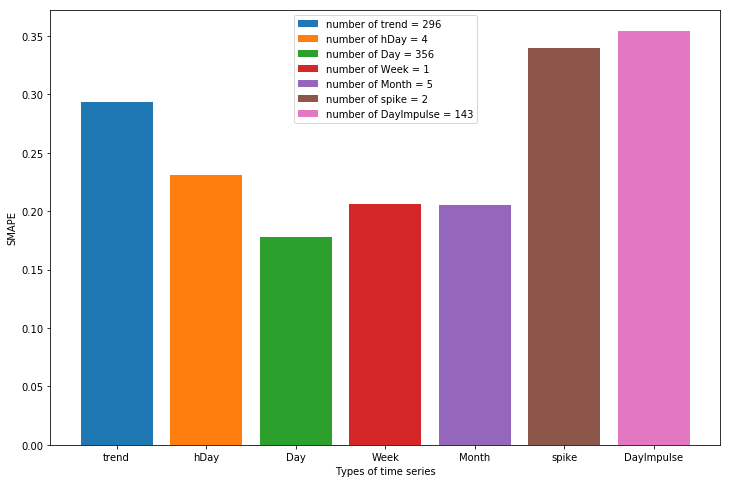

In [29]:
ans = {}
# we have ['trend', 'hDay', 'Day', 'Week', 'Month', 'DayImpulse', 'spike']
ans['trend'] = []
ans['hDay'] = []
ans['Day'] = []
ans['Week'] = []
ans['Month'] = []
ans['spike'] = []
ans['DayImpulse'] = []

for i in range(len(error_list)):
    ans[character_list[i][5]].append(error_list[i])

plt.figure(figsize=(12,8))  
for key, value in ans.items():
    if value:
        print(key, ' smape ', np.mean(value), ' number of series ', len(value))
        plt.bar(key, np.mean(value), label = 'number of {} = {}'.format(key, len(value)))
plt.xlabel('Types of time series')
plt.ylabel('SMAPE')
plt.legend()
plt.show()

### Examine Trend type time series, the error distribution, and will the scale affect the error?

- By plotting the scale (mean amplitude, consistent with the deepAR paper) vs the corresponding SMAPE, we see a correlation here.

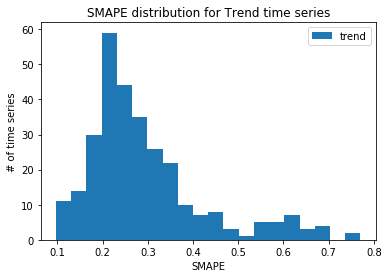

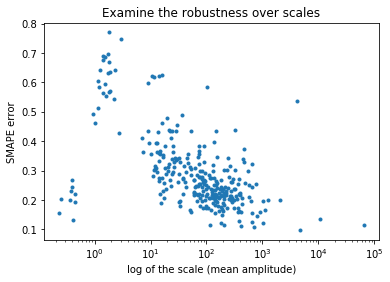

In [30]:
plt.figure()
plt.hist(ans['trend'], bins = 20, label = 'trend')
plt.xlabel('SMAPE')
plt.ylabel('# of time series')
plt.title('SMAPE distribution for Trend time series')
plt.legend()
plt.show()

trend_mean = []
trend_error = []
bad_index = []
good_index = []
for index, error in enumerate(error_list):
    if (character_list[index][5] == 'trend'):
        trend_mean.append(character_list[index][6])
        trend_error.append(error_list[index])
        if (error < 0.15 and character_list[index][6] > 1000):
            good_index.append(index)
        elif (error > 0.5 and character_list[index][6] > 1000):
            bad_index.append(index) 

plt.figure()
plt.plot((trend_mean), trend_error, '.')
plt.xscale('log')
plt.xlabel('log of the scale (mean amplitude)')
plt.ylabel('SMAPE error')
plt.title('Examine the robustness over scales')
plt.show()

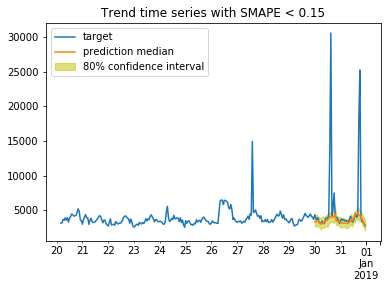

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[18.3573170457995, 5.20230808688465, 17.05739799093754, 5.389779721446839, 4.224863941267166, 'trend', 4671.157191780822, 3008.0756797773415]


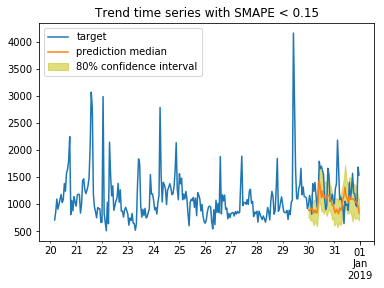

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[15.604668728717064, 0, 12.601819696538229, 7.439261695477216, 0, 'trend', 1019.6470319634703, 530.6589991310528]


In [31]:
for k in good_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length*2:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('Trend time series with SMAPE < 0.15')
    plt.legend(loc = 'best')
    plt.show() 
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

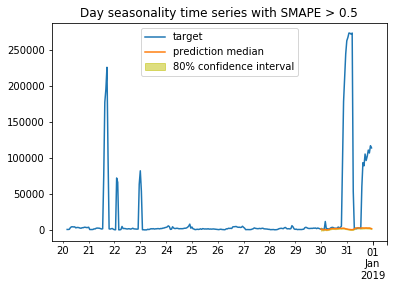

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[10.134296086414391, 0, 0, 0, 0, 'trend', 4120.293378995434, 12058.395374869264]


In [32]:
for k in bad_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length*2:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('Day seasonality time series with SMAPE > 0.5')
    plt.legend(loc = 'best')
    plt.show()
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

### Examine the Day seasonality type time series, the error distribution, and will the scale affect the error?

- Similar to the trend type, we see a correlation between the scale and the SMAPE. The model performs better for larger scales (i.e. time series for popular wiki projects).

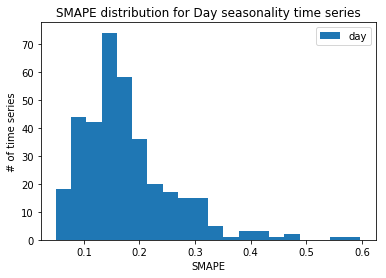

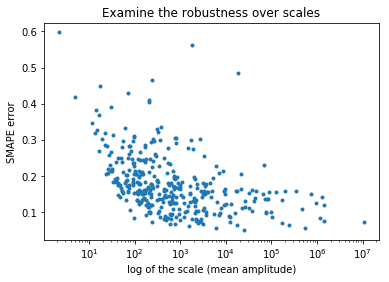

In [33]:
plt.figure()
plt.hist(ans['Day'], bins = 20, label = 'day')
plt.xlabel('SMAPE')
plt.ylabel('# of time series')
plt.title('SMAPE distribution for Day seasonality time series')
plt.legend()
plt.show()

day_mean = []
day_error = []
bad_index = []
good_index = []
for index, error in enumerate(error_list):
    if (character_list[index][5] == 'Day'):
        day_mean.append(character_list[index][6])
        day_error.append(error_list[index])
        if error < 0.15:
            good_index.append(index)
        elif error > 0.4:
            bad_index.append(index)    

plt.figure()
plt.plot((day_mean), day_error, '.')
plt.xscale('log')
plt.xlabel('log of the scale (mean amplitude)')
plt.ylabel('SMAPE error')
plt.title('Examine the robustness over scales')
plt.show()

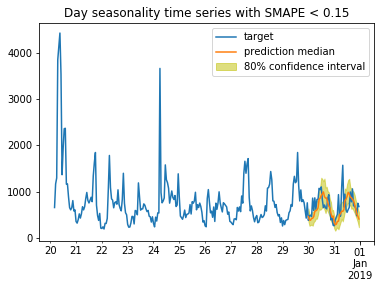

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[8.973994611561459, 0, 14.304273421800099, 0, 4.922032648925727, 'Day', 669.2184931506849, 1101.4334501834949]


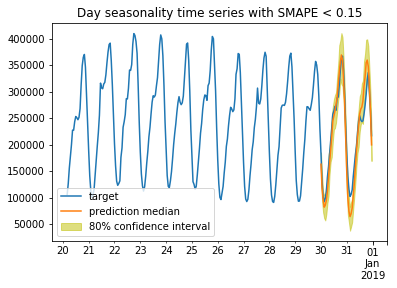

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[9.366193632172015, 19.49257953361858, 56.442911965260635, 4.485444168711687, 0, 'Day', 243617.53253424657, 96089.60703928991]


In [34]:
for k in good_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length*2:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('Day seasonality time series with SMAPE < 0.15')
    plt.legend(loc = 'best')
    plt.show()    
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

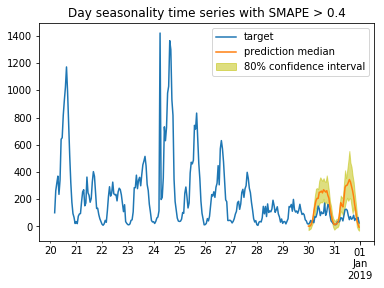

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[19.424270091266827, 10.659815063296724, 34.83633498507346, 12.18186382790792, 0, 'Day', 201.11392694063926, 271.67004528411013]


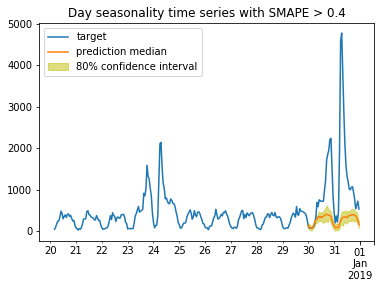

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[19.41042533470602, 15.140689277679058, 37.73321661125712, 4.210930146142056, 0, 'Day', 244.64429223744293, 222.84251652370511]


In [35]:
for k in bad_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length*2:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('Day seasonality time series with SMAPE > 0.4')
    plt.legend(loc = 'best')
    plt.show()    
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

### Examine DayImpulse type time series, why it has such high error?

Find the ones with high SMAPE, and see how the actual and prediction compare to each other.

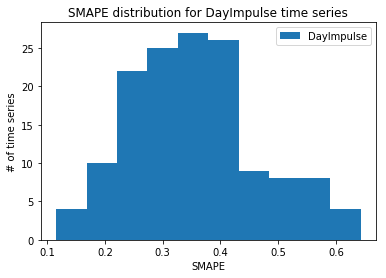

In [36]:
plt.figure()
plt.hist(ans['DayImpulse'], label = 'DayImpulse')
plt.xlabel('SMAPE')
plt.ylabel('# of time series')
plt.title('SMAPE distribution for DayImpulse time series')
plt.legend()
plt.show()

bad_index = []
good_index = []
for index, error in enumerate(error_list):
    if (character_list[index][5] == 'DayImpulse' and error > 0.6):
        bad_index.append(index)
    elif (character_list[index][5] == 'DayImpulse' and error < 0.25):
        good_index.append(index)

#### Now we take a look at the good and bad examples: we plot shorter length (only keep the context + prediction) to better zoom in.

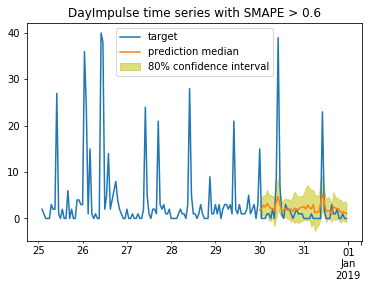

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[9.69394812295933, 12.506328812891947, 11.984547813647513, 0, 0, 'DayImpulse', 5.702283105022831, 15.216615356750177]


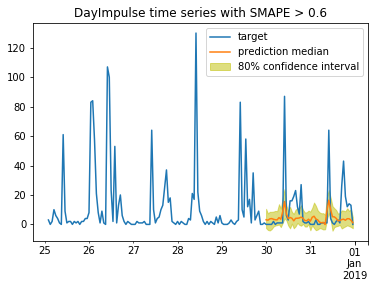

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[8.198917674787866, 15.4609070415219, 14.124947742658422, 0, 4.772296031244396, 'DayImpulse', 6.951027397260274, 20.8824935713444]


In [37]:
for k in bad_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('DayImpulse time series with SMAPE > 0.6')
    plt.legend(loc = 'best')
    plt.show()    
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

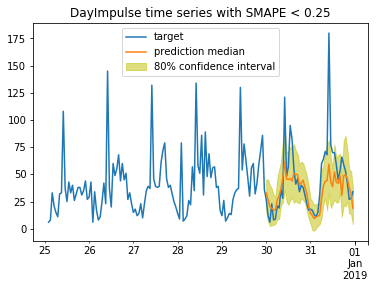

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[14.38890491514568, 14.707319453607008, 40.21717100640066, 0, 0, 'DayImpulse', 46.592351598173515, 53.83259745551839]


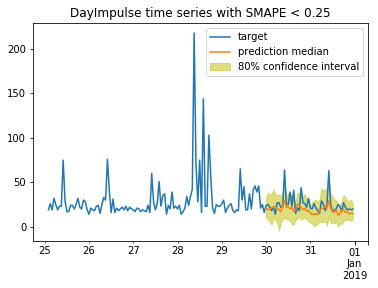

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[7.098609275007841, 9.343190639375914, 11.104972458595583, 0, 0, 'DayImpulse', 25.308333333333334, 32.176245158087724]


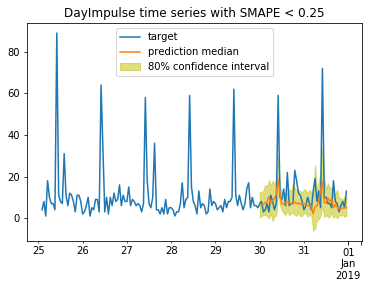

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[14.454996529131448, 9.793414532858737, 15.103078502671334, 0, 0, 'DayImpulse', 14.294863013698631, 29.97260425079613]


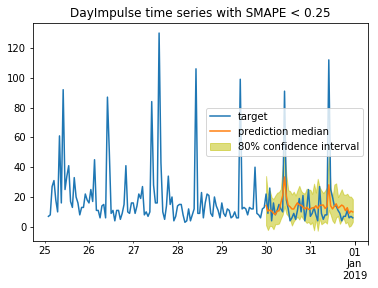

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[10.726859426393156, 14.690960554740775, 13.995919318933618, 0, 0, 'DayImpulse', 21.86472602739726, 26.71648606933508]


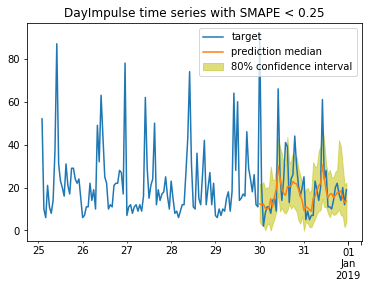

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[16.099629201152094, 13.243552852247074, 21.064284911184526, 0, 0, 'DayImpulse', 21.901826484018265, 22.470923807340018]


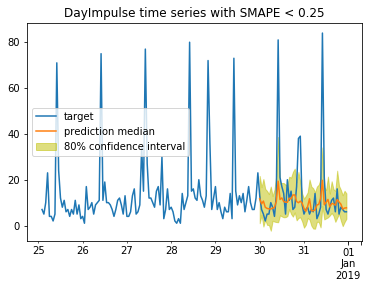

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[8.897257057409654, 10.991042635142541, 10.383273755845869, 0, 0, 'DayImpulse', 21.59337899543379, 42.257994320793074]


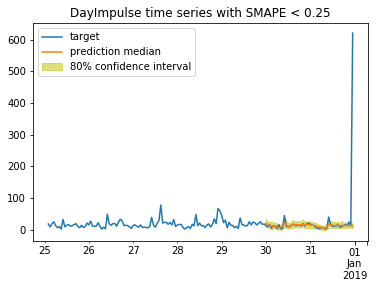

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[15.040644912887895, 16.236833835138043, 25.19340080119428, 12.37118813428284, 0, 'DayImpulse', 21.888013698630136, 19.71115954647212]


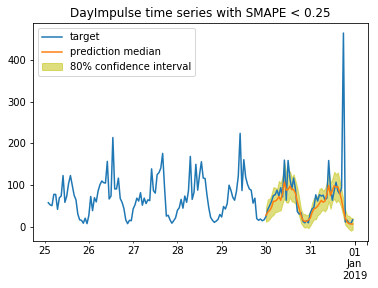

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[12.41978634020924, 22.078983942941534, 48.934318457195836, 0, 0, 'DayImpulse', 76.06324200913242, 55.232781531436764]


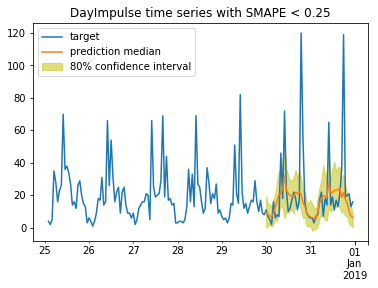

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[12.100463166282875, 8.81399172160262, 41.411118655562746, 0, 0, 'DayImpulse', 24.02488584474886, 21.49378845942629]


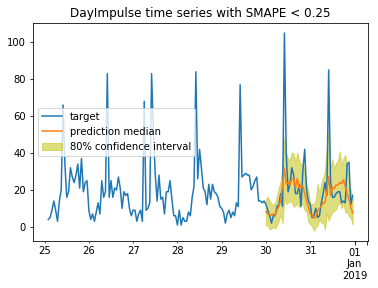

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[23.853448601806555, 15.749886595851926, 34.96553938362958, 12.65042428612678, 0, 'DayImpulse', 35.541438356164385, 34.233763537882616]


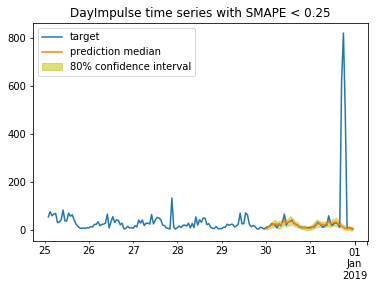

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[25.730774012753052, 9.38826448855617, 31.710868890636725, 0, 0, 'DayImpulse', 19.22077625570776, 24.164308699454683]


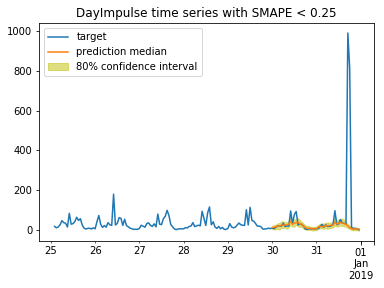

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[22.267108678432734, 10.18693586074185, 37.6458581101828, 0, 0, 'DayImpulse', 25.284474885844748, 30.70983862208616]


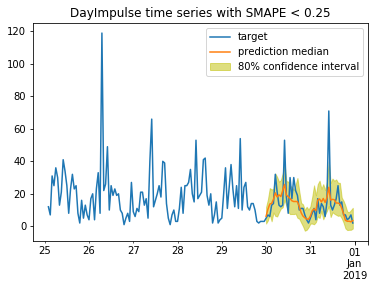

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[11.496852764990484, 0, 34.69839895142544, 0, 0, 'DayImpulse', 17.05890410958904, 19.68462999804047]


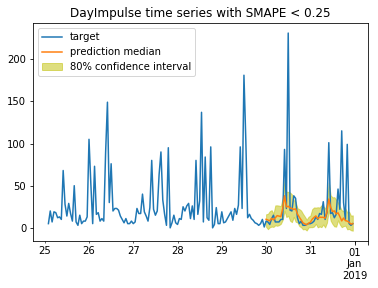

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[12.24227965719723, 5.417056672868007, 30.224958735733203, 0, 0, 'DayImpulse', 20.759018264840183, 25.960789469963657]


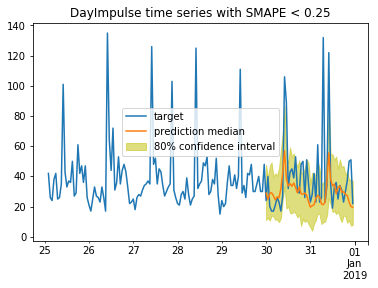

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[0, 9.236257774375815, 26.82350896692998, 0, 0, 'DayImpulse', 37.32374429223744, 31.688621074685134]


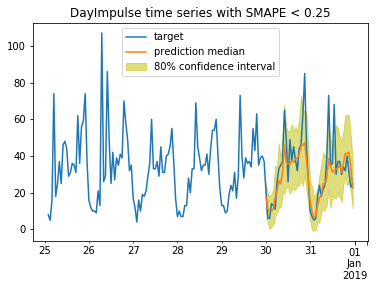

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[6.634792092268229, 33.53318591839137, 40.81946181510605, 4.917645753059107, 3.877133391793806, 'DayImpulse', 38.87237442922375, 25.34914937062269]


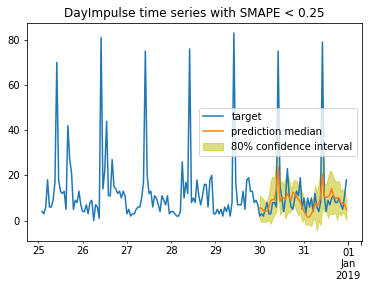

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[7.515408502940632, 17.49946790731494, 20.71729286372817, 0, 0, 'DayImpulse', 14.441095890410958, 26.92501765956661]


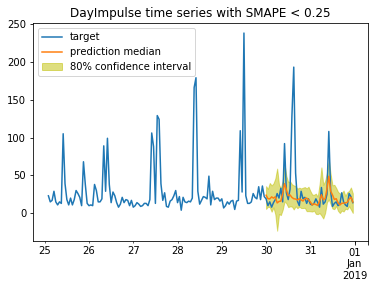

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[13.706826261666851, 13.55806919958897, 13.974726836744749, 0, 0, 'DayImpulse', 27.66118721461187, 38.7657353581733]


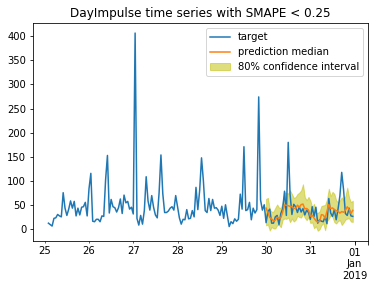

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[12.57497447320185, 23.45363372874239, 34.854525838691835, 4.99456733429738, 0, 'DayImpulse', 39.30776255707762, 26.281202964103915]


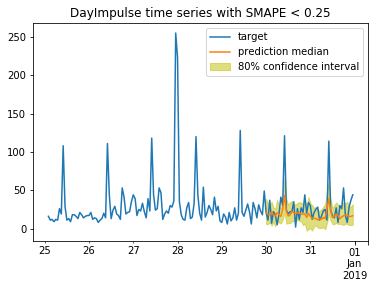

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[13.677413616488826, 16.028663834540097, 15.438349275114037, 0, 0, 'DayImpulse', 25.512328767123286, 33.011003196203625]


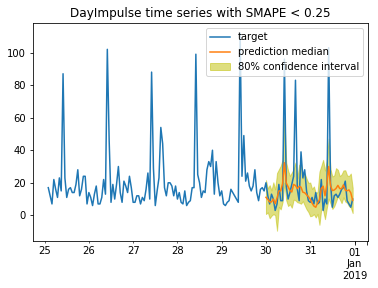

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[5.954786964320144, 12.067609860791299, 12.44137344961757, 0, 0, 'DayImpulse', 21.474543378995435, 34.95010521076512]


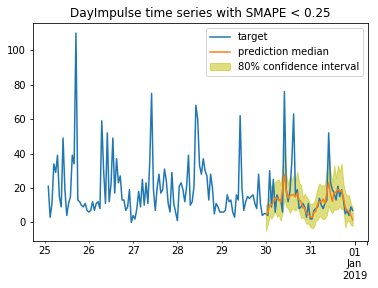

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[5.4435417709290785, 5.295887179709204, 35.894014888455956, 0, 0, 'DayImpulse', 16.623173515981737, 15.2352447360139]


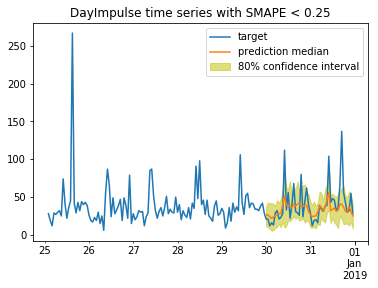

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[19.116368936260532, 11.46517795794496, 19.60445843211784, 0, 0, 'DayImpulse', 35.43550228310502, 39.26090803082942]


In [38]:
for k in good_index:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('DayImpulse time series with SMAPE < 0.25')
    plt.legend(loc = 'best')
    plt.show()   
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

### Delete endpoint

In [39]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: DEMO-deepar-2019-02-05-03-33-24-353
